# Conspicuity Detection in Production by Classical-to-Quantum Transfer Learning

## General setup

### Check hardware info

This notebook was run on Google Colab using GPU. Let's check the hardware info.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Fri Aug  9 19:34:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   74C    P0              24W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install additional libraries

Here, we install additional libraries for the following reasons:

- `torchinfo`: To print the description of the model created by pytorch.
- `torchmetrics`: To compute the accuracy.
- `tensorcircuit`: Used for quantum circuit simulation. This library simulates quantum circuits based on tensor networks; use this library as it is better for batch processing of circuits than pennylane.
- `qiskit`: Used for circuit visualization.
- `cotengra`: This library provides algorithms for finding optimal tensor network contraction paths
- `kahypar`: Used as an optimization backend of cotengra.
- `nevergrad`: Used as an optimization backend of cotengra.

In [10]:
! pip install torchinfo torchmetrics tensorcircuit qiskit[visualization] cotengra kahypar nevergrad

### Import libraries

In this notebook, `pytorch` is used for a backend.

In [2]:
import time
import os
import copy
import warnings

from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics import Accuracy
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import models
from torchvision import transforms as T

import tensorcircuit as tc

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

import json

import cotengra as ctg

# "torch.manual_seed(3407) is all you need"
seed = 3407
torch.manual_seed(seed)
np.random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# tensorcircuit settings

# suppress the warning from cotengra
warnings.filterwarnings(
    "ignore",
    message="The inputs or output of this tree are not ordered."
    "Costs will be accurate but actually contracting requires "
    "ordered indices corresponding to array axes.",
)

tc.set_backend("pytorch")

opt = ctg.ReusableHyperOptimizer(
    minimize="combo",
    methods=["greedy", "kahypar"],
    max_repeats=256,
    max_time=240,
    progbar=True,
    optlib="nevergrad",
    parallel=True,
)

tc.set_contractor(
    "custom",
    optimizer=opt,
    # contraction_info=True,
    preprocessing=True,
    # debug_level=2,
)

functools.partial(<function custom at 0x7b91eec639a0>, optimizer=<cotengra.hyperoptimizers.hyper.ReusableHyperOptimizer object at 0x7b9228bf7e80>, memory_limit=None, debug_level=0, preprocessing=True)

### Set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Install data from Kaggle

In [ ]:
# Mount Google Drive for file access

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import json

# Access https://www.kaggle.com/settings and push "Create New Token" button to download `kaggle.json`
f = open("/content/drive/MyDrive/kaggle.json")
json_data = json.load(f)

os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d danielbacioiu/tig-aluminium-5083

In [ ]:
!unzip /content/tig-aluminium-5083.zip -d data

## Hyper-parameter settings

In [4]:
# Data preprocessing
num_classes = 2 # number of classes, "good weld" or "defective"
batch_size = 32 # batch size
horizontal_flip_prob = 0.5 # probability of horizontal flip

# Optimization
learning_rate = 1e-4 # learning rate of the optimizer
weight_decay = 1e-3 # L2 penalty parameter
epochs = 20 # number of epochs

# Quantum Circuit parameters
n_qubits = 4 # number of qubits
depth = 10 # depth of the quantum circuit
delta = 0.01 # Initial spread of random quantum weights

## Dataset preparation

In [5]:
class Al5083Dataset(Dataset):
    """Al 5083 dataset.
    Modified the code from https://www.kaggle.com/code/miladheidari/deeplearning
    """
    def __init__(self, transform=None, train: bool=True):
        self.transform = transform
        self.path = "/content/data/al5083"
        self.mode = "train" if train else "test"

        with open (f"{self.path}/{self.mode}/{self.mode}.json", "r") as f:
            self.dataset_info = json.load(f)

        self.data = []
        for image_path, label in self.dataset_info.items():
            if label == 0:
                label = 0
            else: # 1, 2, 3, 4, 5
                label = 1
            self.data.append((image_path, label))

    def __len__(self):
        return len(self.dataset_info)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(f"{self.path}/{self.mode}/{image_path}")
        if self.transform:
            image = self.transform(image)
        return image, label

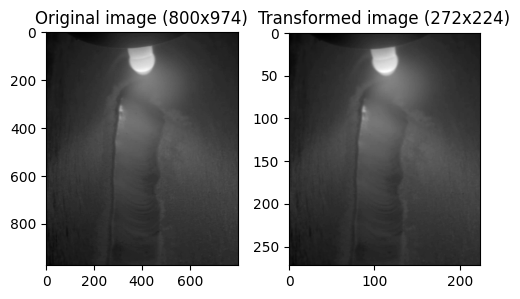

In [6]:
transform = T.Compose([
    T.RandomHorizontalFlip(p=horizontal_flip_prob),
    T.Grayscale(num_output_channels=3),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

fig, axes = plt.subplots(1, 2, figsize=(5, 3))
test_img = Image.open("/content/data/al5083/test/170904-150144-Al 2mm-part2/frame_00322.png")
transformed_img = transform(test_img)
axes[0].imshow(test_img, cmap="gray")
axes[0].set_title(f"Original image ({test_img.size[0]}x{test_img.size[1]})")
axes[1].imshow(transformed_img[0], cmap="gray")
axes[1].set_title(f"Transformed image ({transformed_img.shape[1]}x{transformed_img.shape[2]})")
plt.tight_layout()
plt.show()

train_dataset = Al5083Dataset(
    transform=transform,
    train=True
)

test_dataset = Al5083Dataset(
    transform=transform,
    train=False
)

In [7]:
loader_args = {
    "batch_size": batch_size,
    "num_workers": os.cpu_count(),
    "pin_memory": True,
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **loader_args)
test_dataloader = DataLoader(test_dataset, shuffle=False, **loader_args)

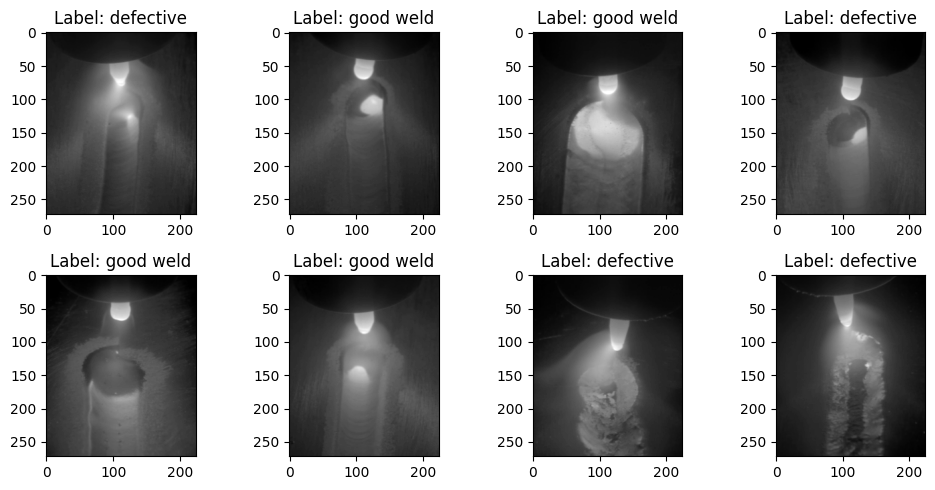

In [8]:
label_names = ["good weld", "defective"]
labels = [0, 1]

# print randomly sampled images
n_samples = 4
n_reps = 2
fig, axes = plt.subplots(n_reps, n_samples, figsize=(10, 5))

for i in range(n_reps):
    for k in range(n_samples):
        rand_img_id = np.random.randint(low = 0, high = len(train_dataset))
        img, label = train_dataset[rand_img_id]

        axes[i, k].set_title(f"Label: {label_names[label]}")
        axes[i, k].imshow(img[0], cmap="gray")

plt.tight_layout()
plt.show()

## Define quantum circuit

Here, we define the quantum circuit that will be trained after classical pre-trained network.
The code is based on the pennylane's quantum transfer learning tutorial (https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning/).

In [9]:
def H_layer(circuit: tc.Circuit):
    """Layer of single-qubit Hadamard gates."""
    for idx in range(n_qubits):
        circuit.h(idx)


def RY_layer(w, circuit: tc.Circuit):
    """Layer of parametrized qubit rotations around the y axis."""
    for idx in range(n_qubits):
        circuit.ry(idx, theta=tc.num_to_tensor(w[idx]))


def entangling_layer(circuit: tc.Circuit):
    """Layer of CNOTs followed by another shifted layer of CNOT."""
    for i in range(0, n_qubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        circuit.cx(i, i + 1)
    for i in range(1, n_qubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        circuit.cx(i, i + 1)

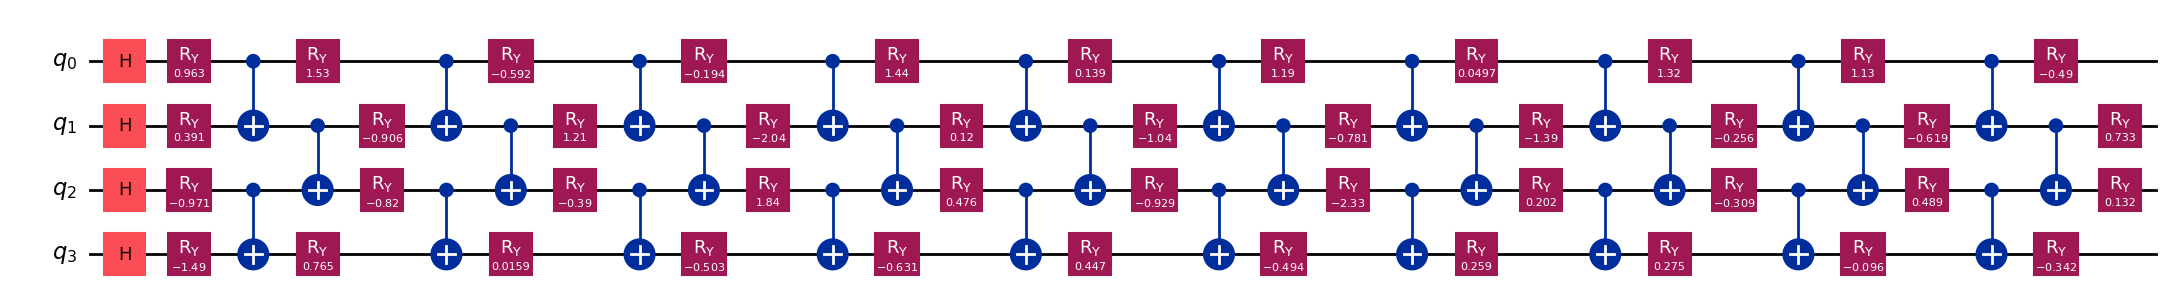

  0%|          | 0/256 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
F=3.24 C=4.47 S=4.00 P=8.86: 100%|██████████| 256/256 [00:02<00:00, 111.88it/s]


In [10]:
def quantum_net(input_features, weights_flat, draw = False):
    """The variational quantum circuit."""
    # assert input_features.shape == (n_qubits,)
    # assert weights_flat.shape == (depth * n_qubits,)

    c = tc.Circuit(n_qubits)

    # Reshape weights
    weights = weights_flat.reshape(depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(c)

    # Embed features in the quantum node
    RY_layer(input_features, c)

    # Sequence of trainable variational layers
    for k in range(depth):
        entangling_layer(c)
        RY_layer(weights[k], c)

    # Draw the circuit
    if draw:
        display(c.draw(output="mpl", fold=-1))

    # Expectation values in the Z basis
    return tuple(
        tc.templates.measurements.parameterized_local_measurements(
            c,
            structures=tc.array_to_tensor([[0, 0, 0, 1] for _ in range(n_qubits)]),
            onehot=False,
        )
    ) # Calculate multiple expectation values at the same time by vmap

quantum_net(
    np.random.normal(size=(n_qubits,)),
    np.random.normal(size=(depth * n_qubits,)),
    draw=True,
)

quantum_net = partial(quantum_net, draw=False)

quantum_net = tc.backend.vmap(quantum_net, vectorized_argnums=0)

quantum_net = tc.interfaces.torch_interface(quantum_net, jit=True)

## Dressed quantum circuit

In [11]:
class DressedQuantumNet(nn.Module):
    """Torch module implementing the dressed quantum net."""

    def __init__(self):
        """Definition of the dressed layout."""

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.params = nn.Parameter(delta * torch.randn(depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """Defining how tensors are supposed to move through the dressed quantum net."""

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to n_qubits
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)

        # batched
        # print("q_in shape", q_in.shape) # (64, 4)
        q_out = quantum_net(q_in, self.params)
        q_out = torch.stack(q_out, dim=1)
        # print("q_out shape", q_out.shape) # (64, 4)

        # non-batched
        # print("q_in shape", q_in.shape) # (64, 4)
        # for elem in q_in: # elem.shape == (64,)
        #     # q_out_elem.shape == (1, 4)
        #     q_out_elem = torch.hstack(quantum_net(elem, self.params)).float().unsqueeze(0)
        #     # q_out_elem.shape == (1, 4) -> (2, 4) -> (3, 4) -> ... -> (64, 4)
        #     q_out = torch.cat((q_out, q_out_elem))
        # print("q_out shape", q_out.shape) # (64, 4)

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

## Hybrid classical-quantum model

We use ResNet18 for classically pre-trained model and replace the last layer of the model by original `DressedQuantumNet`.

In [12]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = models.resnet18(weights=weights)

# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Model summary

In [13]:
summary(
    model_hybrid,
    input_size=(batch_size, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params"],
    depth=2,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 2]                   --
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        9,408
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        128
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 64, 56, 56]          --
│    └─BasicBlock (0)                    [32, 64, 56, 56]          [32, 64, 56, 56]          73,984
│    └─BasicBlock (1)                    [32, 64, 56, 56]          [32, 64, 56, 56]          73,984
├─Sequential (layer2)                    [32, 64, 56, 56]          [32, 128, 28, 28]         --
│    └─BasicBlock (0)  

## Training

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hybrid.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)

In [15]:
# Define scaler for faster process
scaler = torch.cuda.amp.GradScaler()

best_val_acc = 0.0

best_train_losses = []
best_train_accs = []
best_val_losses = []
best_val_accs = []

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    # Train
    model_hybrid.train()
    train_size = len(train_dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(tqdm(train_dataloader, desc="Train")):
        # forward
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Runs the forward pass with autocasting
        with torch.cuda.amp.autocast():
            y_pred = model_hybrid(X)
            loss = loss_fn(y_pred, y)

        # backward
        optimizer.zero_grad(set_to_none=True)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        # Save train loss
        train_loss.append(loss.item())

        # Save train accuracy
        acc = accuracy(y_pred, y)
        train_acc.append(acc.item())

    # Validation
    model_hybrid.eval()
    test_size = len(test_dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(tqdm(test_dataloader, desc="Validation")):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        with torch.no_grad():
            y_pred = model_hybrid(X)
            loss = loss_fn(y_pred, y)

        # Save validation loss
        val_loss.append(loss.item())

        # Save validation accuracy
        acc = accuracy(y_pred, y)
        val_acc.append(acc.item())

    # Save results
    print(
        f"Epoch {epoch}/{epochs} | train loss: {np.mean(train_loss):.3f} | "
        f"train acc: {np.mean(train_acc):.3f} | val loss: {np.mean(val_loss):.3f} | "
        f"val acc: {np.mean(val_acc):.3f}"
    )
    best_train_losses.append(np.mean(train_loss))
    best_train_accs.append(np.mean(train_acc))
    best_val_losses.append(np.mean(val_loss))
    best_val_accs.append(np.mean(val_acc))
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)
        torch.save(model_hybrid.state_dict(), "model_best.pt")

Epoch 1/20


Validation: 100%|██████████| 206/206 [00:19<00:00, 10.31it/s]


Epoch 1/20 | train loss: 0.451 | train acc: 0.844 | val loss: 0.391 | val acc: 0.898
Epoch 2/20


Validation: 100%|██████████| 206/206 [00:20<00:00, 10.05it/s]


Epoch 2/20 | train loss: 0.314 | train acc: 0.922 | val loss: 0.299 | val acc: 0.939
Epoch 3/20


Validation: 100%|██████████| 206/206 [00:20<00:00, 10.02it/s]


Epoch 3/20 | train loss: 0.258 | train acc: 0.938 | val loss: 0.267 | val acc: 0.932
Epoch 4/20


Validation: 100%|██████████| 206/206 [00:20<00:00, 10.03it/s]


Epoch 4/20 | train loss: 0.220 | train acc: 0.946 | val loss: 0.224 | val acc: 0.942
Epoch 5/20


Validation: 100%|██████████| 206/206 [00:20<00:00,  9.96it/s]


Epoch 5/20 | train loss: 0.193 | train acc: 0.949 | val loss: 0.197 | val acc: 0.947
Epoch 6/20


Validation: 100%|██████████| 206/206 [00:20<00:00, 10.00it/s]


Epoch 6/20 | train loss: 0.170 | train acc: 0.954 | val loss: 0.183 | val acc: 0.941
Epoch 7/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.69it/s]


Epoch 7/20 | train loss: 0.156 | train acc: 0.954 | val loss: 0.174 | val acc: 0.939
Epoch 8/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.59it/s]


Epoch 8/20 | train loss: 0.140 | train acc: 0.959 | val loss: 0.159 | val acc: 0.944
Epoch 9/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.62it/s]


Epoch 9/20 | train loss: 0.130 | train acc: 0.959 | val loss: 0.137 | val acc: 0.951
Epoch 10/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.66it/s]


Epoch 10/20 | train loss: 0.123 | train acc: 0.960 | val loss: 0.136 | val acc: 0.950
Epoch 11/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.65it/s]


Epoch 11/20 | train loss: 0.116 | train acc: 0.962 | val loss: 0.139 | val acc: 0.947
Epoch 12/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.67it/s]


Epoch 12/20 | train loss: 0.113 | train acc: 0.961 | val loss: 0.136 | val acc: 0.944
Epoch 13/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.62it/s]


Epoch 13/20 | train loss: 0.106 | train acc: 0.964 | val loss: 0.121 | val acc: 0.952
Epoch 14/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.68it/s]


Epoch 14/20 | train loss: 0.104 | train acc: 0.964 | val loss: 0.124 | val acc: 0.951
Epoch 15/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.64it/s]


Epoch 15/20 | train loss: 0.099 | train acc: 0.965 | val loss: 0.133 | val acc: 0.945
Epoch 16/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.63it/s]


Epoch 16/20 | train loss: 0.102 | train acc: 0.963 | val loss: 0.135 | val acc: 0.943
Epoch 17/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.70it/s]


Epoch 17/20 | train loss: 0.098 | train acc: 0.965 | val loss: 0.156 | val acc: 0.931
Epoch 18/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.72it/s]


Epoch 18/20 | train loss: 0.092 | train acc: 0.967 | val loss: 0.113 | val acc: 0.954
Epoch 19/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.70it/s]


Epoch 19/20 | train loss: 0.090 | train acc: 0.967 | val loss: 0.122 | val acc: 0.949
Epoch 20/20


Validation: 100%|██████████| 206/206 [00:21<00:00,  9.72it/s]

Epoch 20/20 | train loss: 0.090 | train acc: 0.967 | val loss: 0.132 | val acc: 0.944


In [16]:
from google.colab import files
files.download("/content/model_best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Check results

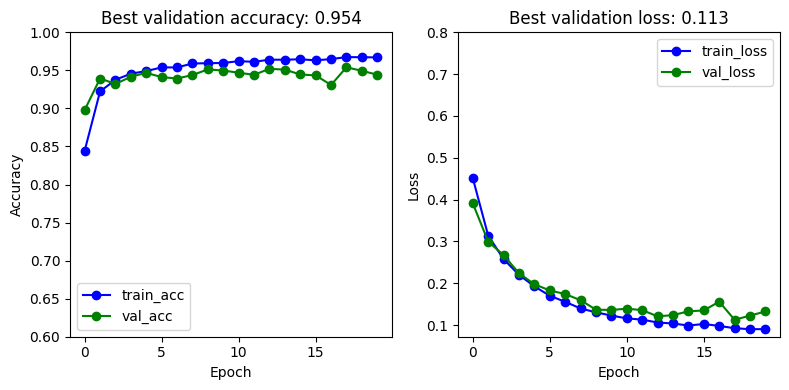

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(np.arange(epochs), best_train_accs, "-ob", label="train_acc")
ax1.plot(np.arange(epochs), best_val_accs, "-og", label="val_acc")
ax1.set_title(f"Best validation accuracy: {best_val_acc:.3f}")
ax1.set_ylabel(f"Accuracy")
ax1.set_ylim([0.6, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(np.arange(epochs), best_train_losses, "-ob", label="train_loss")
ax2.plot(np.arange(epochs), best_val_losses, "-og", label="val_loss")
ax2.set_title(f"Best validation loss: {np.min(best_val_losses):.3f}")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=0.8)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

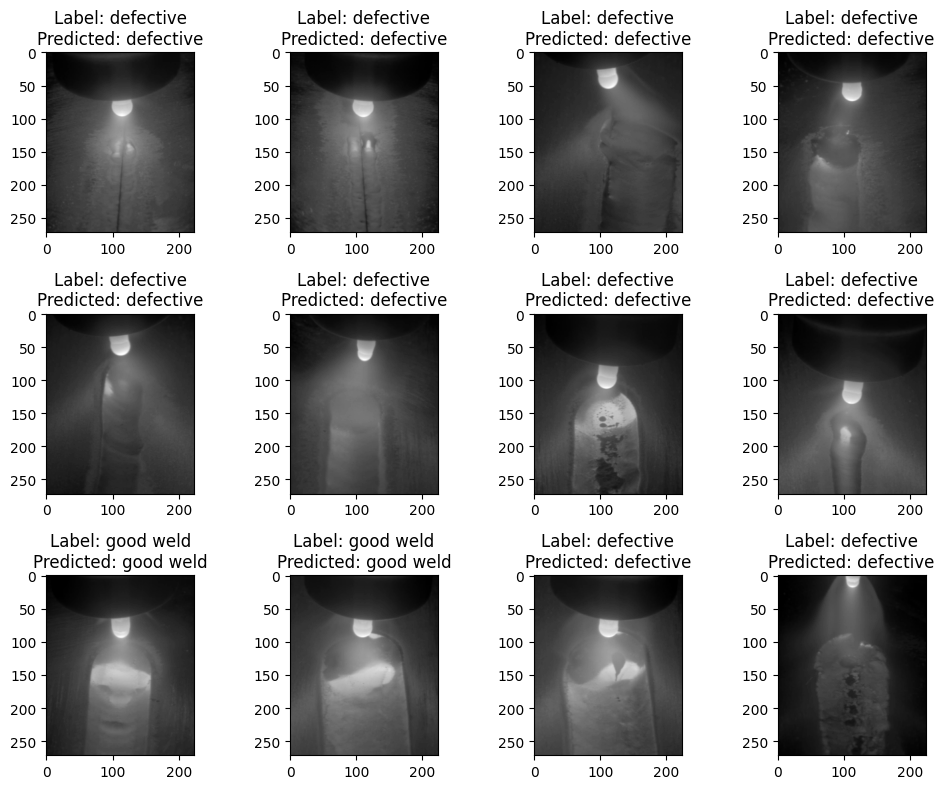

In [18]:
label_names = ["good weld", "defective"]
labels = [0, 1]

# print randomly sampled images
n_samples = 4
n_reps = 3
fig, axes = plt.subplots(n_reps, n_samples, figsize=(10, 8))

for i in range(n_reps):
    for k in range(n_samples):
        rand_img_id = np.random.randint(low = 0, high = len(train_dataset))
        img, label = train_dataset[rand_img_id]
        pred_label = model_hybrid(img.unsqueeze(0).to(device)).argmax().item()

        axes[i, k].set_title(f"Label: {label_names[label]}\nPredicted: {label_names[pred_label]}")
        axes[i, k].imshow(img[0], cmap="gray")

plt.tight_layout()
plt.show()